In [1]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import csv
import networkx as nx
import matplotlib.pyplot as plt
import math


In [2]:
m = gp.Model('Maritime Inventory Routing Problem')

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-18


# Creating classes in order organize the code

In [3]:
class Port:
    def __init__(self, capacity, inventory, rate, price, berth_limit, port_fee, max_amount, min_amount, number, isLoadingPort):
        self.capacity = capacity
        self.inventory = inventory
        self.rate = rate
        self.price = price 
        self.berth_limit = berth_limit 
        self.port_fee = port_fee
        self.max_amount = max_amount
        self.min_amount = min_amount
        self.number = number
        self.isLoadingPort = isLoadingPort
        
    def __repr__(self):
        return f'Port {self.number}'
    

class Node:
    def __init__(self, port, time):
        self.port = port
        self.time = time
        self.tuple = (port.number if port else None, time)
        self.incoming_arcs = set()
        self.outgoing_arcs = set()
        self.berths = port.berth_limit if port else None
    
    def __repr__(self):
        return str(self.tuple)


class Arc:
    def __init__(self, origin_node, destination_node, distance, cost, travel_time, speed, is_waiting_arc):
        self.origin_node = origin_node
        self.destination_node = destination_node
        self.tuple = (origin_node, destination_node)
        self.distance = distance
        self.cost = cost
        self.travel_time = travel_time
        self.speed = speed
        self.is_waiting_arc = is_waiting_arc
            
    def __repr__(self):
        return f'{self.origin_node} -> {self.destination_node} --- Cost: {self.cost} --- Speed: {self.speed}'

class Vessel:
    def __init__(self, max_inventory, initial_inventory, max_operating_quantity, number):
        self.max_inventory = int(max_inventory)
        self.inventory = initial_inventory
        self.max_operating_quantity = max_operating_quantity
        self.number = number
        self.arcs = set()
        self.all_arcs_v = set()
        
    def __repr__(self):
        return f'Vessel {self.number}'
        

### Read in file

In [4]:
# Read the content of the provided file
with open("data/LR1_1_DR1_3_VC1_V7a.txt", 'r') as file:
    content = file.read()

In [5]:
def parse_metadata(content):
    metadata = {}
    
    # Extract lines between "----- MetaData -----" and the next section separator (empty line or end of file)
    start_index = content.index("----- MetaData -----") + len("----- MetaData -----")
    end_index = content.find("\n\n", start_index) if "\n\n" in content[start_index:] else len(content)
    metadata_section = content[start_index:end_index].strip().split("\n")
    
    for line in metadata_section:
        if ":" in line:
            # Split the line at ":" to extract the key and value
            key, value = line.split(":")
            # Store the key-value pair in the dictionary
            metadata[key.strip()] = value.strip()
    
    return metadata

## Read in metadata

In [6]:
'''Are not using these values:
    spotMarketPricePerUnit = float(metadata['spotMarketPricePerUnit'])
    spotMarketDiscountFactor = float(metadata['spotMarketDiscountFactor'])
    perPeriodRewardForFinishingEarly = float(metadata.get('perPeriodRewardForFinishingEarly', 0))
    attemptCost = float(metadata.get('attemptCost', 0))
    constantForSinglePeriodAlphaSlack = float(metadata.get('constantForSinglePeriodAlphaSlack', 0))
    constantForCumulativeAlphaSlack = float(metadata.get('constantForCumulativeAlphaSlack', 0))'''

def read_and_assign_metadata_from_content(content):
    # Parse the metadata
    metadata = parse_metadata(content)
    
    # Assign the metadata values to variables
    numPeriods = int(metadata['numPeriods'].split()[-1])  # Extract the last word (number) from the string
    numCommodities = int(metadata['numCommodities'])
    numLoadingRegions = int(metadata['numLoadingRegions'])
    numDischargingRegions = int(metadata['numDischargingRegions'])
    numLoadingPortsInRegion = [int(x) for x in metadata['numLoadingPortsInRegion'][1:-1].split()]
    numDischargingPortsInRegion = [int(x) for x in metadata['numDischargingPortsInRegion'][1:-1].split()]
    numVesselClasses = int(metadata['numVesselClasses'])
    numTermVesselsInClass = [int(x) for x in metadata['numTermVesselsInClass'][1:-1].split()]
    hoursPerPeriod = int(metadata['hoursPerPeriod'])
    spotMarketPricePerUnit = float(metadata['spotMarketPricePerUnit'])
    spotMarketDiscountFactor = float(metadata['spotMarketDiscountFactor'])
    perPeriodRewardForFinishingEarly = float(metadata.get('perPeriodRewardForFinishingEarly', 0))
    attemptCost = float(metadata.get('attemptCost', 0))
    constantForSinglePeriodAlphaSlack = float(metadata.get('constantForSinglePeriodAlphaSlack', 0))
    constantForCumulativeAlphaSlack = float(metadata.get('constantForCumulativeAlphaSlack', 0))
    
    # Return the assigned variables
    return {
        'numPeriods': numPeriods,
        'numCommodities': numCommodities,
        'numLoadingRegions': numLoadingRegions,
        'numDischargingRegions': numDischargingRegions,
        'numLoadingPortsInRegion': numLoadingPortsInRegion,
        'numDischargingPortsInRegion': numDischargingPortsInRegion,
        'numVesselClasses': numVesselClasses,
        'numTermVesselsInClass': numTermVesselsInClass,
        'hoursPerPeriod': hoursPerPeriod,
        'spotMarketPricePerUnit': spotMarketPricePerUnit,
        'spotMarketDiscountFactor': spotMarketDiscountFactor,
        'perPeriodRewardForFinishingEarly': perPeriodRewardForFinishingEarly,
        'attemptCost': attemptCost,
        'constantForSinglePeriodAlphaSlack': constantForSinglePeriodAlphaSlack,
        'constantForCumulativeAlphaSlack': constantForCumulativeAlphaSlack}

In [7]:

# Using the refactored function with the already-read content
metadata_from_content = read_and_assign_metadata_from_content(content)
# Change the numPeriods manually.
metadata_from_content['numPeriods'] = 20
metadata_from_content

{'numPeriods': 20,
 'numCommodities': 1,
 'numLoadingRegions': 1,
 'numDischargingRegions': 1,
 'numLoadingPortsInRegion': [1],
 'numDischargingPortsInRegion': [3],
 'numVesselClasses': 1,
 'numTermVesselsInClass': [7],
 'hoursPerPeriod': 24,
 'spotMarketPricePerUnit': 1.0,
 'spotMarketDiscountFactor': 0.999,
 'perPeriodRewardForFinishingEarly': 0.01,
 'attemptCost': 0.01,
 'constantForSinglePeriodAlphaSlack': 0.5,
 'constantForCumulativeAlphaSlack': 1.0}

### Read in port data

In [8]:
def parse_region_table(content):
    # Extract the region table section
    start_index = content.index("----- Region Table ----") + len("----- Region Table ----")
    end_index = content.find("-----", start_index)  # Find the next section separator
    region_section = content[start_index:end_index].strip().split("\n")[1:]  # Exclude the header line
    regions = {}
    for line in region_section:
        if "Note:" not in line:  # Exclude the note lines
            attribute, *values = line.split()
            regions[attribute] = values
    return regions


def parse_port_table_for_region(content, region_index):
    # Extract the port table section for the specified region
    search_str = f"----- Port Table For Region {region_index} ----"
    start_index = content.index(search_str) + len(search_str)
    end_index = content.find("-----", start_index)  # Find the next section separator
    port_section = content[start_index:end_index].strip().split("\n")[1:]  # Exclude the header line
    ports = {}
    for line in port_section:
        attribute, *values = line.split()
        ports[attribute] = values
    return ports


In [9]:
# Extract region and port information
regions_info = parse_region_table(content)
ports_info = {f"Region {i}": parse_port_table_for_region(content, i) for i in range(len(regions_info['NumPorts']))}
ports_info

{'Region 0': {'Capacity': ['594'],
  'Inventory': ['297'],
  'Rate': ['99'],
  'Price': [],
  'BerthLimit': ['1'],
  'PortFee': ['38'],
  'maxAmt': ['300'],
  'minAmt': ['35'],
  'C2R': ['ratio', '6']},
 'Region 1': {'Capacity': ['351', '510', '312'],
  'Inventory': ['168', '255', '156'],
  'Rate': ['-39', '-34', '-26'],
  'Price': ['5', '5', '5'],
  'BerthLimit': ['1', '1', '1'],
  'PortFee': ['57', '58', '66'],
  'maxAmt': ['300', '300', '259'],
  'minAmt': ['50', '35', '20'],
  'C2R': ['ratio', '9', '15', '12']}}

### Create the ports

In [10]:
def create_ports_from_info_with_loading(ports_info):
    all_ports = {}
    tot_num = 1
    
    for region_idx, (region, port_attributes) in enumerate(ports_info.items()):
        region_ports = []
        for i in range(len(port_attributes['Capacity'])):
            port = Port(
                capacity=int(port_attributes['Capacity'][i]) if 'Capacity' in port_attributes else None,
                inventory=int(port_attributes['Inventory'][i]) if 'Inventory' in port_attributes else None,
                rate=abs(int(port_attributes['Rate'][i])) if 'Rate' in port_attributes else None,
                price=int(port_attributes['Price'][i]) if 'Price' in port_attributes and port_attributes['Price'] else None,
                berth_limit=int(port_attributes['BerthLimit'][i]) if 'BerthLimit' in port_attributes else None,
                port_fee=int(port_attributes['PortFee'][i]) if 'PortFee' in port_attributes else None,
                max_amount=int(port_attributes['maxAmt'][i]) if 'maxAmt' in port_attributes else None,
                min_amount=int(port_attributes['minAmt'][i]) if 'minAmt' in port_attributes else None,
                number=int(tot_num),  # Using 1 to numports+1 as the port number
                isLoadingPort=1 if region_idx == 0 else -1)  # Set loadingPort to True if the region is the first one
            region_ports.append(port)
            tot_num += 1
        all_ports[region] = region_ports
    return all_ports

In [11]:
all_ports = create_ports_from_info_with_loading(ports_info)

In [12]:
# Create a list of all ports
ports = []
for region, region_ports in all_ports.items():
    ports.extend(region_ports)
ports

[Port 1, Port 2, Port 3, Port 4]

# Initial Parameters

All parameters should be set below

In [13]:
# Time periods
numTimePeriods = metadata_from_content['numPeriods']
timePeriodRange = list(range(1, numTimePeriods+1))

# Number of vessels
numVessels = metadata_from_content['numTermVesselsInClass'][0]

# Speed interval
max_speed_k = 15
min_speed_k = 8

# Fuel price in USD per ton
fuel_price = 500

# Change the numPeriods manually.
# metadata_from_content['numPeriods'] = 5
'''Should change the code so that we set the num_periods here'''


'Should change the code so that we set the num_periods here'

In [14]:
def parse_vessel_table(content):
    # Extract the vessel table section
    start_index = content.index("----- Vessel Table ----") + len("----- Vessel Table ----")
    end_index = content.find("-----", start_index)  # Find the next section separator
    vessel_section = content[start_index:end_index].strip().split("\n")[1:]  # Exclude the header line
    
    vessels = {}
    for line in vessel_section:
        if "Note:" not in line:  # Exclude the note lines
            attribute, *values = line.split()
            vessels[attribute] = values
    return vessels

In [15]:
# Extract vessel information
vessels_info = parse_vessel_table(content)
vessels_info

{'Type': ['Term', 'Term', 'Term', 'Term', 'Term', 'Term', 'Term'],
 'Class': ['0', '0', '0', '0', '0', '0', '0'],
 'Capacity': ['300', '300', '300', '300', '300', '300', '300']}

In [16]:
# Create a dictionary with key = vessel class and value = vessel object
vessels = {}
tot = 1
for vessel_class in range(metadata_from_content['numVesselClasses']):
    vessel_list = []
    vessels_in_class = metadata_from_content['numTermVesselsInClass'][vessel_class]
    for i in range(vessels_in_class):
        vessel_list.append(Vessel(
            max_inventory=int(vessels_info['Capacity'][i]),
            initial_inventory=int(0),
            max_operating_quantity=int(vessels_info['Capacity'][i]),
            number=tot
        ))
        tot += 1
    vessels[vessel_class] = vessel_list

# We only have one vessel class. Convert the dictionary to a list
vessels = vessels[0]
vessels


[Vessel 1, Vessel 2, Vessel 3, Vessel 4, Vessel 5, Vessel 6, Vessel 7]

In [17]:
# Create the regular nodes
regularNodes = []
for t in range(1, numTimePeriods+1):
    for port in ports:
        node = Node(port=port, time=t)
        regularNodes.append(node)
    
# Create fictional source and sink port
sourcePort = Port(capacity=None, inventory=None, rate=None, price=None, berth_limit=len(vessels), port_fee=0, max_amount=None, min_amount=None, number=0, isLoadingPort=True)
sinkPort = Port(capacity=None, inventory=None, rate=None, price=None, berth_limit=len(vessels), port_fee=0, max_amount=None, min_amount=None, number=len(ports)+1, isLoadingPort=False)

# Create source and sink node
sourceNode = Node(port=sourcePort, time=0)
sinkNode = Node(port=sinkPort, time=numTimePeriods+1)

nodes = [sourceNode] + regularNodes + [sinkNode]

# Create a node dictionary with key = (port, time) tuple and value = node object
nodeDict = {}
for node in nodes:
    nodeDict[node.tuple] = node

### Read in arc data

In [18]:
def parse_full_distance_matrix(content):
    # Extract the full distance matrix section
    start_str = "----- FullDistanceMatrix ----"
    start_index = content.index(start_str) + len(start_str)
    end_index = content.find("-----", start_index)  # Find the next section separator
    matrix_section = content[start_index:end_index].strip().split("\n")[2:]  # Exclude the header lines
    
    # Convert the matrix section to a 2D list of distances
    distances = []
    for line in matrix_section:
        try:
            distance_row = list(map(float, line.split()[1:]))  # Excluding the leading port number
            distances.append(distance_row)
        except ValueError:
            continue
    
    return distances

# Extracting the full distance matrix from the file content
full_distance_matrix = parse_full_distance_matrix(content)
full_distance_matrix


[[0.0, 5792.83, 5730.94, 5663.71],
 [5792.83, 0.0, 326.1, 338.92],
 [5730.94, 326.1, 0.0, 67.42],
 [5663.71, 338.92, 67.42, 0.0]]

In [19]:
full_distance_matrix =[[0.0, 500, 1000, 1250],
 [500, 0.0, 326.1, 338.92],
 [1000, 326.1, 0.0, 67.42],
 [1250, 338.92, 67.42, 0.0]]
 
        



In [20]:
# Convert full_distance_matrix from km to nautical miles
# 1 nautical mile = 1.852 km
def km_to_nautical_miles(km):
    return km / 1.852

In [21]:
def convert_matrix_to_nautical_miles(matrix):
    return [[km_to_nautical_miles(distance) for distance in row] for row in matrix]

In [22]:
full_distance_matrix_nm = convert_matrix_to_nautical_miles(full_distance_matrix)
full_distance_matrix_nm

[[0.0, 269.97840172786175, 539.9568034557235, 674.9460043196544],
 [269.97840172786175, 0.0, 176.07991360691145, 183.00215982721383],
 [539.9568034557235, 176.07991360691145, 0.0, 36.40388768898488],
 [674.9460043196544, 183.00215982721383, 36.40388768898488, 0.0]]

In [23]:
def fuel_consumption_speed_nm(speed, nautical_miles):
    """
    Calculate the fuel consumption based on speed and nautical miles.

    Args:
    - speed (float): Speed of the vessel in knots.
    - nautical miles (float): .

    Returns:
    - float: Fuel consumption in tons.
    """
    return  (0.16 * (speed / 14) ** 3) * nautical_miles
    


# def fuel_consumption_func(speed, days):
#     """
#     Calculate the fuel consumption based on speed and days.

#     Args:
#     - speed (float): Speed of the vessel in knots.
#     - days (float): Duration in days.

#     Returns:
#     - float: Fuel consumption in tons.
#     """
#     return  (50 * (speed / 14) ** 3) * days


def calc_cost(fuel_consumption):
    """
    Calculate the cost based on fuel consumption.

    Args:
    - fuel_consumption (float): Fuel consumption in tons.

    Returns:
    - float: Cost in USD.
    """
    return fuel_consumption * 500

# Function to calculate discrete max speed based on distance and global max speed
def calculate_minimum_timesteps_and_speed(distance_nm, max_speed_k, min_speed_k):
    """
    Determine the minimum timesteps and speed based on distance and max speed.

    Args:
    - distance_nm (float): Distance in nautical miles.
    - max_speed_k (float): Maximum speed in knots.
    - min_speed_k (float): Minimum speed in knots.

    Returns:
    - tuple: Minimum timesteps and speed.
    """
    hours = distance_nm / max_speed_k
    minimum_timesteps = math.ceil(hours / 24)
    speed = distance_nm / (minimum_timesteps * 24)
    return minimum_timesteps, max(speed, min_speed_k)
    
# Based on rounded_hours and speed calculate the next speeds
def create_arc_info(speed, minimum_timesteps, departure, origin_port, destination_port, lowest_speed, distance_to_port, vessel, is_waiting_arc):
    # Create a list of tuples with the speed and the time period
    '''arc_info: (speed in knots, timesteps for sailing, time period of departure, time period of arrival, origin port, destination port, fuel_consumption)'''
    
    arrival_time = departure + minimum_timesteps
    if arrival_time > numTimePeriods:
        return None
    if is_waiting_arc:
        fuel_consumption = 0
        arc_info = [(speed, 1, departure, departure + minimum_timesteps, origin_port, destination_port, fuel_consumption, distance_to_port, vessel, is_waiting_arc)]
    else:
        fuel_consumption = fuel_consumption_speed_nm(speed=speed, nautical_miles=distance_to_port)
        arc_info = [(speed, minimum_timesteps, departure, departure + minimum_timesteps, origin_port, destination_port, fuel_consumption, distance_to_port, vessel, is_waiting_arc)]
    
        timesteps = minimum_timesteps+1
        while True:
            
            # Calculate the next speed
            speed = distance_to_port / ((timesteps)*24)
            # If the speed is lower than the lowest speed, break the loop
            if speed < lowest_speed:
                break
            fuel_consumption = fuel_consumption_speed_nm(speed=speed, nautical_miles=distance_to_port)
            arrival_time = departure + timesteps
            # Otherwise, add the speed to the list
            arc_info.append((speed, timesteps, departure, arrival_time, origin_port, destination_port, fuel_consumption, distance_to_port, vessel, is_waiting_arc))
            # Increment the time period
            timesteps += 1
            arrival_time = departure + timesteps
            if arrival_time > numTimePeriods:
                break
       
    return arc_info
        

### Need to have starting positions for each vessel. 
### That way we can find the earliest time a vessel can be at each port.

For now we just randomly generate distances to each of the ports, without thinking about whether it is practically possible to have these distances. 

In [24]:
# Ensure reproducibility of the random numbers
np.random.seed(0)

source_distances = {}
# Creating manual starting positions for the vessels
for vessel in vessels:
    # Create a list of the distance from the source node to each of the ports
    '''
        0.00  5792.83  5730.94  5663.71 
    1  5792.83     0.00   326.10   338.92 
    2  5730.94   326.10     0.00    67.42 
    3  5663.71   338.92    67.42     0.00 
    '''
    # Randomly generate 4 distances for each vessel
    distances = np.random.randint(0, 400, size=len(ports))
    source_distances[vessel] = distances
    
source_distances[vessels[0]] = [3600, 4000, 5730.94, 5663.71]
   

In [25]:
# Use the source_distances to create a source_times dictionary
source_times = {}
for vessel, distances in source_distances.items():
    source_times[vessel] = [math.ceil((distance / max_speed_k)/24) for distance in distances]
    
source_times

{Vessel 1: [10, 12, 16, 16],
 Vessel 2: [1, 1, 1, 1],
 Vessel 3: [1, 1, 1, 1],
 Vessel 4: [1, 1, 1, 1],
 Vessel 5: [2, 1, 1, 1],
 Vessel 6: [1, 1, 1, 1],
 Vessel 7: [1, 1, 1, 1]}

In [26]:
# Create a source_fuel_consumption as well
source_fc = {}
for vessel, distances in source_distances.items():
    source_fc[vessel] = [fuel_consumption_speed_nm(speed=max_speed_k, nautical_miles=distance)for distance in distances]
source_fc

{Vessel 1: [708.4548104956268,
  787.1720116618076,
  1127.80889212828,
  1114.578498542274],
 Vessel 2: [63.56413994169097,
  49.39504373177843,
  38.37463556851312,
  70.64868804664724],
 Vessel 3: [1.771137026239067,
  41.52332361516035,
  54.511661807580175,
  47.62390670553936],
 Vessel 4: [57.46355685131196,
  17.120991253644316,
  13.775510204081634,
  17.31778425655977],
 Vessel 5: [77.93002915451895,
  61.7930029154519,
  37.981049562682216,
  7.6749271137026245],
 Vessel 6: [17.120991253644316,
  34.24198250728863,
  17.31778425655977,
  66.3192419825073],
 Vessel 7: [32.470845481049565,
  4.919825072886297,
  65.53206997084548,
  14.169096209912537]}

In [27]:
nodeDict

{(0, 0): (0, 0),
 (1, 1): (1, 1),
 (2, 1): (2, 1),
 (3, 1): (3, 1),
 (4, 1): (4, 1),
 (1, 2): (1, 2),
 (2, 2): (2, 2),
 (3, 2): (3, 2),
 (4, 2): (4, 2),
 (1, 3): (1, 3),
 (2, 3): (2, 3),
 (3, 3): (3, 3),
 (4, 3): (4, 3),
 (1, 4): (1, 4),
 (2, 4): (2, 4),
 (3, 4): (3, 4),
 (4, 4): (4, 4),
 (1, 5): (1, 5),
 (2, 5): (2, 5),
 (3, 5): (3, 5),
 (4, 5): (4, 5),
 (1, 6): (1, 6),
 (2, 6): (2, 6),
 (3, 6): (3, 6),
 (4, 6): (4, 6),
 (1, 7): (1, 7),
 (2, 7): (2, 7),
 (3, 7): (3, 7),
 (4, 7): (4, 7),
 (1, 8): (1, 8),
 (2, 8): (2, 8),
 (3, 8): (3, 8),
 (4, 8): (4, 8),
 (1, 9): (1, 9),
 (2, 9): (2, 9),
 (3, 9): (3, 9),
 (4, 9): (4, 9),
 (1, 10): (1, 10),
 (2, 10): (2, 10),
 (3, 10): (3, 10),
 (4, 10): (4, 10),
 (1, 11): (1, 11),
 (2, 11): (2, 11),
 (3, 11): (3, 11),
 (4, 11): (4, 11),
 (1, 12): (1, 12),
 (2, 12): (2, 12),
 (3, 12): (3, 12),
 (4, 12): (4, 12),
 (1, 13): (1, 13),
 (2, 13): (2, 13),
 (3, 13): (3, 13),
 (4, 13): (4, 13),
 (1, 14): (1, 14),
 (2, 14): (2, 14),
 (3, 14): (3, 14),
 (4, 14): 

# Generate the arcs

In [28]:
print(sourcePort.number)
print(sourceNode.port.number)

0
0


In [29]:
source_distances

{Vessel 1: [3600, 4000, 5730.94, 5663.71],
 Vessel 2: array([323, 251, 195, 359]),
 Vessel 3: array([  9, 211, 277, 242]),
 Vessel 4: array([292,  87,  70,  88]),
 Vessel 5: array([396, 314, 193,  39]),
 Vessel 6: array([ 87, 174,  88, 337]),
 Vessel 7: array([165,  25, 333,  72])}

In [30]:
source_arcs_info = []
print('arc_info = [(speed, minimum_timesteps, departure, departure + minimum_timesteps, origin_port, destination_port, fuel_consumption, distance_to_port, vessel, is_waiting_arc)')

# Find the list of all ports once
all_port_numbers = [port.number for port in ports]

vessel_start_times = {}
for vessel in vessels:
    node = sourceNode
    origin_port = node.port.number
    source_distances_v = source_distances[vessel]
    start_times = []
    # Loop through ports excluding the current node's port
    for destination_port_number in all_port_numbers:
        destination_port_idx = destination_port_number - 1
        distance_nm = source_distances_v[destination_port_idx]

        # Calculate the earliest time period and the speed
        minimum_timesteps, speed = calculate_minimum_timesteps_and_speed(distance_nm=distance_nm, max_speed_k=max_speed_k, min_speed_k=min_speed_k)
        
        # Create arc info matrix and append to node arcs
        arc_info_matrix = create_arc_info(speed=speed, minimum_timesteps=minimum_timesteps, departure=0, origin_port=node.port.number, destination_port=destination_port_number, lowest_speed=min_speed_k, distance_to_port=distance_nm, vessel=vessel, is_waiting_arc = False)
        source_arcs_info.append(arc_info_matrix)
        start_times.append(minimum_timesteps)
        # print(f'Appended {minimum_timesteps} to start times for vessel {vessel.number}. Start times: {start_times}')
        
    vessel_start_times[vessel] = start_times
    
source_arcs_info

arc_info = [(speed, minimum_timesteps, departure, departure + minimum_timesteps, origin_port, destination_port, fuel_consumption, distance_to_port, vessel, is_waiting_arc)


[[(15.0, 10, 0, 10, 0, 1, 708.4548104956268, 3600, Vessel 1, False),
  (13.636363636363637,
   11,
   0,
   11,
   0,
   1,
   532.2725848952869,
   3600,
   Vessel 1,
   False),
  (12.5, 12, 0, 12, 0, 1, 409.9854227405249, 3600, Vessel 1, False),
  (11.538461538461538,
   13,
   0,
   13,
   0,
   1,
   322.4646383685146,
   3600,
   Vessel 1,
   False),
  (10.714285714285714,
   14,
   0,
   14,
   0,
   1,
   258.18323997654034,
   3600,
   Vessel 1,
   False),
  (10.0, 15, 0, 15, 0, 1, 209.9125364431487, 3600, Vessel 1, False),
  (9.375, 16, 0, 16, 0, 1, 172.96260021865888, 3600, Vessel 1, False),
  (8.823529411764707,
   17,
   0,
   17,
   0,
   1,
   144.20004284462183,
   3600,
   Vessel 1,
   False),
  (8.333333333333334,
   18,
   0,
   18,
   0,
   1,
   121.47716229348883,
   3600,
   Vessel 1,
   False)],
 [(13.88888888888889,
   12,
   0,
   12,
   0,
   2,
   624.8825220858479,
   4000,
   Vessel 1,
   False),
  (12.820512820512821,
   13,
   0,
   13,
   0,
   2,
   491

In [31]:
# Now that we have the earliest node that we can reach any given for for any given vessel, we can create the rest of the source arcs
# Loop through all vessels
for vessel in vessels:
    all_port_numbers = [port.number for port in ports]
    
    for port_number in all_port_numbers:
        # Find the start time for the port-vessel pair
        start_time = vessel_start_times[vessel][port_number-1]
        current_timesteps = start_time + 1
        # Extract all nodes with the current port number
        nodes_with_port = [node for node in nodes if node.port.number == port_number]
        # Extract all nodes with time > start_time
        nodes_with_port_and_time = [node for node in nodes_with_port if node.time > start_time]
        # Loop through nodes_with_port_and_time with the earliest node first
        for node in sorted(nodes_with_port_and_time, key=lambda x: x.time):
            
            # Calculate the distance from the previous node
            distance_nm = source_distances[vessel][port_number-1]
            # calculate the speed
            speed = distance_nm / (current_timesteps * 24)
            
            if speed < min_speed_k:
                break
            
            # Create arc info matrix and append to node arcs
            arc_info_matrix = create_arc_info(speed=speed, minimum_timesteps=current_timesteps, departure=0, origin_port=sourceNode.port.number, destination_port=node.port.number, lowest_speed=min_speed_k, distance_to_port=distance_nm, vessel=vessel, is_waiting_arc = False)
            source_arcs_info.append(arc_info_matrix)
            print(f'Appending extra_arc for vessel {vessel.number} with speed {speed} and timesteps {current_timesteps} to port {node.port.number}')
            current_timesteps += 1
            
            

Appending extra_arc for vessel 1 with speed 13.636363636363637 and timesteps 11 to port 1
Appending extra_arc for vessel 1 with speed 12.5 and timesteps 12 to port 1
Appending extra_arc for vessel 1 with speed 11.538461538461538 and timesteps 13 to port 1
Appending extra_arc for vessel 1 with speed 10.714285714285714 and timesteps 14 to port 1
Appending extra_arc for vessel 1 with speed 10.0 and timesteps 15 to port 1
Appending extra_arc for vessel 1 with speed 9.375 and timesteps 16 to port 1
Appending extra_arc for vessel 1 with speed 8.823529411764707 and timesteps 17 to port 1
Appending extra_arc for vessel 1 with speed 8.333333333333334 and timesteps 18 to port 1
Appending extra_arc for vessel 1 with speed 12.820512820512821 and timesteps 13 to port 2
Appending extra_arc for vessel 1 with speed 11.904761904761905 and timesteps 14 to port 2
Appending extra_arc for vessel 1 with speed 11.11111111111111 and timesteps 15 to port 2
Appending extra_arc for vessel 1 with speed 10.4166666

In [32]:
# # Start with the arcs from the source node
# source_arcs = {}
# for vessel, distances in source_distances.items():
#     for i, distance in enumerate(distances):
        
#         # Find the destination_node. Port number is i+1. Time period is found in the source_times dictionary
#         destination_node = nodeDict[(i+1, source_times[vessel][i])]
#         cost = fuel_consumption_speed_nm(speed=max_speed_k, nautical_miles=distance) * fuel_price
#         travel_time = source_times[vessel][i]
#         # Create the arc
#         arc = Arc(origin_node=sourceNode, destination_node=destination_node, distance=distance, cost=cost, travel_time=travel_time, speed=max_speed_k, is_waiting_arc=False)
        
#         # Add the arc info to the source arcs for the vessel
#         source_arcs.setdefault(vessel, []).append(arc)        
        
# source_arcs

### We need to use this as the starting point of the arc generation. 
### We can remove all the arcs that are incoming to a given port before the source arc reaches that node, and We can also remove all arcs that are going out from the given port before the source arc has reached it. 

In [33]:

print('arc_info = [(speed, minimum_timesteps, departure, departure + minimum_timesteps, origin_port, destination_port, fuel_consumption, distance_to_port, vessel, is_waiting_arc))')

all_info = []

# Find the list of all ports once
all_port_numbers = [port.number for port in ports]

for vessel in vessels:
    for node in nodeDict.values():
        # print(f"Processing node: {node}")
        node_arcs = []

        # If the node is the source or the sink, skip it. We have already created the arcs for the source node
        if node.port.number in [0, len(ports) + 1]:
            continue
        
        # If the node is before the earliest start time, skip it
        start_time = source_times[vessel][node.port.number - 1]
        if node.time < start_time:
            continue
        

        origin_port_idx = node.port.number - 1

        # Loop through ports excluding the current node's port
        for destination_port_number in all_port_numbers:
            if destination_port_number == node.port.number:
                # Create a waiting arc to the same port in the next time period
                # Create arc info matrix and append to node arcs
                arc_info_matrix = create_arc_info(speed=0, minimum_timesteps=1, departure=node.time, origin_port=node.port.number, destination_port=destination_port_number, lowest_speed=0, distance_to_port=0, vessel=vessel, is_waiting_arc = True)
                node_arcs.append(arc_info_matrix)
            else:

                destination_port_idx = destination_port_number - 1
                distance_nm = full_distance_matrix_nm[origin_port_idx][destination_port_idx]

                # Calculate the earliest time period and the speed
                minimum_timesteps, speed = calculate_minimum_timesteps_and_speed(distance_nm=distance_nm, max_speed_k=max_speed_k, min_speed_k=min_speed_k)
                
                # Need to ensure that an arc is not created if the arrival time is before the earliest start time for that port
                arrival_time = node.time + minimum_timesteps
                if arrival_time < source_times[vessel][destination_port_idx]:
                    continue
                if arrival_time > numTimePeriods:
                    continue
                # destination_node_tuple = (destination_port_number, arrival_time)
                

                # Create arc info matrix and append to node arcs
                arc_info_matrix = create_arc_info(speed=speed, minimum_timesteps=minimum_timesteps, departure=node.time, origin_port=node.port.number, destination_port=destination_port_number, lowest_speed=min_speed_k, distance_to_port=distance_nm, vessel=vessel, is_waiting_arc = False)
                node_arcs.append(arc_info_matrix)

        all_info.append(node_arcs)


arc_info = [(speed, minimum_timesteps, departure, departure + minimum_timesteps, origin_port, destination_port, fuel_consumption, distance_to_port, vessel, is_waiting_arc))


In [34]:
# Add the source arcs to the all_info list
all_info.append(source_arcs_info)

In [35]:
for ls in all_info:
    for arc in ls:
        # If arc is not none
        if arc:        
            if arc[0][3]== 21:
                print(arc)

In [36]:

arc_dict = {}
vessel_arcs = {}
waiting_arcs = {}

# Iterate through the list of tuples and add arcs to nodes
for sublist in all_info:
    for subsublist in sublist:
        if subsublist == None:
            continue
        for tuple_data in subsublist:
            
            speed, timesteps, departure, arrival, origin_port_number, destination_port_number, fuel_consumption, distance_nm, vessel, is_waiting_arc = tuple_data
            
            if arrival > numTimePeriods:
                continue
            # Calculate the cost
            cost = calc_cost(fuel_consumption)

            # Find the existing nodes for origin and destination
            origin_node_tuple = (origin_port_number, departure)
            destination_node_tuple = (destination_port_number, arrival)
            if destination_node_tuple == (4, 21):
                print(f'Issue. From {origin_node_tuple} to {destination_node_tuple}')

            origin_node_obj = None
            destination_node_obj = None

            # Find the corresponding Node objects in the list of nodes
            origin_node_obj = nodeDict[origin_node_tuple]
            destination_node_obj = nodeDict[destination_node_tuple]
            # for node in nodes:
            #     if node.tuple == origin_node:
            #         origin_node_obj = node
            #     elif node.tuple == destination_node:
            #         destination_node_obj = node

            if origin_node_obj and destination_node_obj:
                # Create an arc and add it to the nodes
                arc = Arc(origin_node=origin_node_obj, destination_node=destination_node_obj, distance=distance_nm, cost=cost, travel_time=timesteps, speed=speed, is_waiting_arc=is_waiting_arc)
                origin_node_obj.outgoing_arcs.add(arc)
                destination_node_obj.incoming_arcs.add(arc)
                arc_dict[(origin_node_tuple, destination_node_tuple, vessel)] = arc
                if is_waiting_arc:
                    waiting_arcs.setdefault(vessel, []).append(arc)
                vessel_arcs.setdefault(vessel, []).append(arc)


In [37]:
# # Add source arcs to the arc_dict
# for vessel, arcs in source_arcs.items():
#     for arc in arcs:
#         arc_dict[(arc.origin_node.tuple, arc.destination_node.tuple, vessel)] = arc
#         vessel_arcs.setdefault(vessel, []).append(arc)

In [37]:
# source arcs for vessel 1
for arc in source_arcs[vessels[0]]:
    print(arc)
    

TypeError: list indices must be integers or slices, not Vessel

In [38]:
# Add one from the source node to the sink node for every vessel
for vessel in vessels:
    arc = Arc(origin_node=sourceNode, destination_node=sinkNode, distance=0, cost=0, travel_time=0, speed=0, is_waiting_arc=False)
    sourceNode.outgoing_arcs.add(arc)
    sinkNode.incoming_arcs.add(arc)
    arc_dict[(sourceNode.tuple, sinkNode.tuple, vessel)] = arc
    vessel_arcs.setdefault(vessel, []).append(arc)
    
# Add one arc from every node to the sink node for every vessel
for vessel in vessels:
    for node in nodeDict.values():
        # Skip the source and sink nodes
        if node.port.number in [0, len(ports) + 1]:
            continue
        
        # If the node is before the earliest start time, skip it
        start_time = source_times[vessel][node.port.number - 1]
        if node.time < start_time:
            continue
        
        
        # Create an arc from the node to the sink node
        arc = Arc(origin_node=node, destination_node=sinkNode, distance=0, cost=0, travel_time=0, speed=0, is_waiting_arc=False)
        node.outgoing_arcs.add(arc)
        sinkNode.incoming_arcs.add(arc)
        arc_dict[(node.tuple, sinkNode.tuple, vessel)] = arc
        vessel_arcs.setdefault(vessel, []).append(arc)
        
        

In [39]:
source_times

{Vessel 1: [10, 12, 16, 16],
 Vessel 2: [1, 1, 1, 1],
 Vessel 3: [1, 1, 1, 1],
 Vessel 4: [1, 1, 1, 1],
 Vessel 5: [2, 1, 1, 1],
 Vessel 6: [1, 1, 1, 1],
 Vessel 7: [1, 1, 1, 1]}

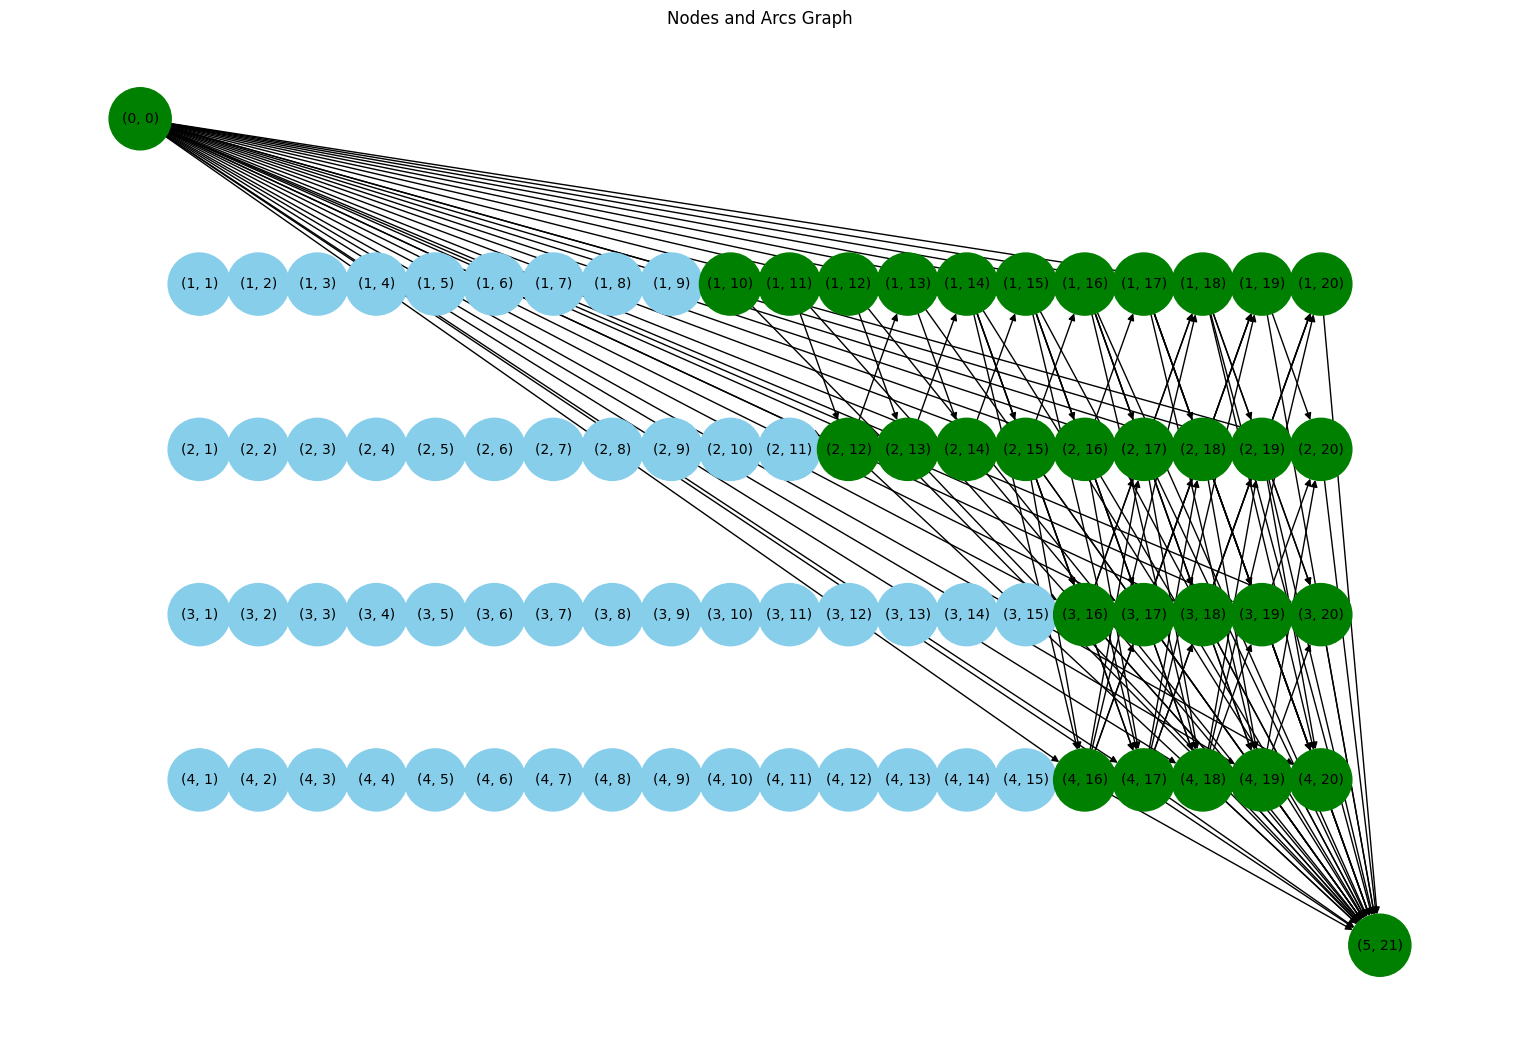

In [42]:
# Visualize the network for vessel 1
vessel = vessels[0]

# Create a directed graph
G = nx.DiGraph()

# Add nodes to the graph
for node in nodes:
    G.add_node(str(node.tuple))

# Add edges (arcs) to the graph
for arc in vessel_arcs[vessel]:
    G.add_edge(str(arc.origin_node.tuple), str(arc.destination_node.tuple))

# Determine nodes with incoming and outgoing arcs
nodes_with_incoming_arcs = [node for node, degree in G.in_degree() if degree > 0]
nodes_with_outgoing_arcs = [node for node, degree in G.out_degree() if degree > 0]

# Create a list to hold node colors
node_colors = []
for node in G.nodes():
    if node in nodes_with_incoming_arcs or node in nodes_with_outgoing_arcs:
        node_colors.append('green')  # Color for nodes with arcs
    else:
        node_colors.append('skyblue')  # Default color

# Resetting the y_offset and y_spacing
y_offset = 10
y_spacing = -30  # Increase vertical spacing for better clarity

# Manually specify the positions for each node
pos = {}

# Manually set the position for the source and sink nodes
pos["(0, 0)"] = (0, 0)  # Positioning source node at leftmost, middle height
pos["(5, 5)"] = (5 * 10, 0)  # Positioning sink node at rightmost, middle height

for node in nodes:
    # Skip setting position for source and sink nodes
    if str(node.tuple) in ["(0, 0)", "(5, 5)"]:
        continue
    port_index = node.port.number  # Get port number to determine y-coordinate
    # The x-coordinate is based on time, the y-coordinate is fixed for nodes with the same port
    pos[str(node.tuple)] = (node.time * 10, port_index * y_spacing)  # Multiplying time by 10 for better horizontal spacing

# Drawing the graph using the adjusted positions
plt.figure(figsize=(15, 10))
nx.draw(G, pos, with_labels=True, node_size=2000, node_color=node_colors, font_size=10)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Nodes and Arcs Graph")
plt.show()


In [ ]:
full_distance_matrix =
[[0.0, 500, 1000, 1250],
 [500, 0.0, 326.1, 338.92],
 [1000, 326.1, 0.0, 67.42],
 [1250, 338.92, 67.42, 0.0]]

In [55]:
vessel_arcs

{Vessel 1: [(1, 1) -> (1, 2) --- Cost: 0 --- Speed: 0,
  (1, 1) -> (2, 3) --- Cost: 16476.394625310437 --- Speed: 10.416666666666666,
  (1, 1) -> (3, 4) --- Cost: 78110.31526073099 --- Speed: 13.88888888888889,
  (1, 1) -> (3, 5) --- Cost: 32952.789250620874 --- Speed: 10.416666666666666,
  (1, 1) -> (4, 5) --- Cost: 80451.14563139866 --- Speed: 13.020833333333334,
  (2, 1) -> (1, 3) --- Cost: 16476.394625310437 --- Speed: 10.416666666666666,
  (2, 1) -> (2, 2) --- Cost: 0 --- Speed: 0,
  (2, 1) -> (3, 2) --- Cost: 23849.28426386548 --- Speed: 13.5875,
  (2, 1) -> (4, 2) --- Cost: 27826.651294727577 --- Speed: 14.121666666666668,
  (3, 1) -> (1, 4) --- Cost: 78110.31526073099 --- Speed: 13.88888888888889,
  (3, 1) -> (1, 5) --- Cost: 32952.789250620874 --- Speed: 10.416666666666666,
  (3, 1) -> (2, 2) --- Cost: 23849.28426386548 --- Speed: 13.5875,
  (3, 1) -> (3, 2) --- Cost: 0 --- Speed: 0,
  (3, 1) -> (4, 2) --- Cost: 1006.3860058309035 --- Speed: 8,
  (4, 1) -> (1, 5) --- Cost: 804

In [35]:
# # For each vessel, find the earliest time period it is able to reach each port
# vessel_starting_times = {}
# for vessel, distances in source_distances.items():
#     # Create a list of the earliest time period for each port
#     earliest_times = []
#     for distance in distances:
#         # Calculate the earliest time period and the speed
#         minimum_timesteps, speed = calculate_minimum_timesteps_and_speed(distance_nm=distance, max_speed_k=max_speed_k, min_speed_k=min_speed_k)
#         earliest_times.append(minimum_timesteps)
#     vessel_starting_times[vessel] = earliest_times

In [36]:
# Use the vessel_starting_times to create the sets of arcs for each vessel.
# First extract all arcs from the arc_dict
all_arcs_set = set()

for vessel in vessels:
    # Create a new set of arcs for each vessel
    arcs = vessel_arcs[vessel]
    # Create a list of all tuples from the arcs in all_arcs_set
    all_arcs_tuples = [arc.tuple for arc in all_arcs_set]
    # if arc.tuple in the tuples of all_arcs_set continue
    arcs_to_add = set()
    for arc in arcs:
        print(arc)
        if arc.tuple in all_arcs_tuples:
            continue
        # Otherwise, add the arc to the set
        arcs_to_add.update({arc})
    # Add arcs to the set
    all_arcs_set.update(arcs_to_add)

(1, 1) -> (1, 2) --- Cost: 0 --- Speed: 0
(1, 1) -> (2, 3) --- Cost: 16476.394625310437 --- Speed: 10.416666666666666
(1, 1) -> (3, 4) --- Cost: 78110.31526073099 --- Speed: 13.88888888888889
(1, 1) -> (3, 5) --- Cost: 32952.789250620874 --- Speed: 10.416666666666666
(1, 1) -> (4, 5) --- Cost: 80451.14563139866 --- Speed: 13.020833333333334
(2, 1) -> (1, 3) --- Cost: 16476.394625310437 --- Speed: 10.416666666666666
(2, 1) -> (2, 2) --- Cost: 0 --- Speed: 0
(2, 1) -> (3, 2) --- Cost: 23849.28426386548 --- Speed: 13.5875
(2, 1) -> (4, 2) --- Cost: 27826.651294727577 --- Speed: 14.121666666666668
(3, 1) -> (1, 4) --- Cost: 78110.31526073099 --- Speed: 13.88888888888889
(3, 1) -> (1, 5) --- Cost: 32952.789250620874 --- Speed: 10.416666666666666
(3, 1) -> (2, 2) --- Cost: 23849.28426386548 --- Speed: 13.5875
(3, 1) -> (3, 2) --- Cost: 0 --- Speed: 0
(3, 1) -> (4, 2) --- Cost: 1006.3860058309035 --- Speed: 8
(4, 1) -> (1, 5) --- Cost: 80451.14563139866 --- Speed: 13.020833333333334
(4, 1) ->

In [37]:
# creating arcs for each vessel
for vessel in vessels:
    # Create a new set of arcs for each vessel
    arcs_ex_source_arcs = vessel_arcs[vessel]
    source_arcs_v = source_arcs[vessel]
    vessel.all_arcs_v.update(arcs_ex_source_arcs)
    vessel.all_arcs_v.update(source_arcs_v)
    print(vessel.all_arcs_v)
    break
    
    

{(1, 4) -> (5, 6) --- Cost: 0 --- Speed: 0, (4, 4) -> (5, 6) --- Cost: 0 --- Speed: 0, (0, 0) -> (4, 1) --- Cost: 18892.128279883385 --- Speed: 15, (4, 3) -> (3, 4) --- Cost: 1006.3860058309035 --- Speed: 8, (3, 1) -> (2, 2) --- Cost: 23849.28426386548 --- Speed: 13.5875, (3, 1) -> (1, 4) --- Cost: 78110.31526073099 --- Speed: 13.88888888888889, (3, 2) -> (5, 6) --- Cost: 0 --- Speed: 0, (2, 3) -> (5, 6) --- Cost: 0 --- Speed: 0, (2, 2) -> (2, 3) --- Cost: 0 --- Speed: 0, (4, 1) -> (1, 5) --- Cost: 80451.14563139866 --- Speed: 13.020833333333334, (4, 4) -> (2, 5) --- Cost: 27826.651294727577 --- Speed: 14.121666666666668, (2, 2) -> (1, 4) --- Cost: 16476.394625310437 --- Speed: 10.416666666666666, (2, 1) -> (2, 2) --- Cost: 0 --- Speed: 0, (4, 1) -> (4, 2) --- Cost: 0 --- Speed: 0, (3, 1) -> (1, 5) --- Cost: 32952.789250620874 --- Speed: 10.416666666666666, (1, 1) -> (1, 2) --- Cost: 0 --- Speed: 0, (2, 3) -> (2, 4) --- Cost: 0 --- Speed: 0, (3, 4) -> (3, 5) --- Cost: 0 --- Speed: 0, (

In [38]:
# '''Using the parsed data instead'''

# # Create the set of arcs associated with vessel v in a time-space model
# # Note: The arcs need to be revised so that only feasible travels are included
# def generate_all_arcs(regularNodes, vesselClass):
#     arc_dict = {}
#     vessels_in_vessel_class = vessels[vesselClass]
#     for v in vessels_in_vessel_class:
#         # Arcs between all nodes
#         for n in regularNodes:
#             arcs = set()
#             outgoing_arcs_for_node_n_vessel_v = outgoing_arcs_v2(node=n, nodes=nodes, vessel=v, vessel_class=vessel_class)
#             arcs.update(outgoing_arcs_for_node_n_vessel_v)
#             arc_dict[(n.tuple, v)] = arcs
#     return arc_dict

## Create IN and OUT sets for nodes

# Starting with Gurobi

In [39]:
'''Creating the variables'''
'''Binary first'''
# x is the binary variable that indicates whether a vessel travels on arc a, where and arc is a route frome one node to another node.
x = m.addVars(((arc.tuple, vessel) for vessel in vessels for arc in vessel_arcs[vessel]) , vtype=gp.GRB.BINARY, name="x")

# o is the binary variable that indicates whether vessel v is operating (loading/unloading) at node n
o = m.addVars(((node.port.number, node.time, vessel) for node in regularNodes for vessel in vessels), vtype=gp.GRB.BINARY, name="o")

'''Continuous varibles'''
# q is the amount of product loaded or unloaded at port i by vessel v at time t
q_bounds = {(node.port.number, node.time, vessel): min(vessel.max_inventory, node.port.capacity) for node in regularNodes for vessel in vessels}
q = m.addVars(q_bounds.keys(), lb=0, ub=q_bounds, vtype=gp.GRB.CONTINUOUS, name="q")

# s is the amount of product at port i at the end of period t
s_bounds = {(node.port.number, node.time): node.port.capacity for node in regularNodes}
s = m.addVars(s_bounds.keys(), lb=0, ub=s_bounds, vtype=gp.GRB.CONTINUOUS, name="s")

# Create s vars for each port in time period 0
s_bounds_source = {(port.number, 0): port.capacity for port in ports}
s_source = m.addVars(s_bounds_source.keys(), lb=0, ub=s_bounds, vtype=gp.GRB.CONTINUOUS, name="s")
s.update(s_source)

# w is the amount of product on board of vessel v at the end of time period t
w_bounds = {(t, vessel): vessel.max_inventory for vessel in vessels for t in timePeriodRange}
w = m.addVars(w_bounds.keys(), lb=0, ub=w_bounds, vtype=gp.GRB.CONTINUOUS, name="w")
w_bounds_source = {(0, vessel): vessel.max_inventory for vessel in vessels}
w_source = m.addVars(w_bounds_source.keys(), lb=0, ub=w_bounds, vtype=gp.GRB.CONTINUOUS, name="w")
w.update(w_source)

m.update()

In [40]:
len(x), len(o), len(q), len(s), len(w)

(547, 140, 140, 24, 42)

In [41]:
# Create a dict where the arc.tuple is the key and arc.cost is the value
'''
costs = {(arc.tuple): arc.cost for arc in all_arcs_set}
''' 
#costs = {(arc.tuple): arc.cost for arc in all_arcs_set}
costs = {(arc.tuple, vessel): arc.cost for vessel in vessels for arc in vessel_arcs[vessel] }
m.update()

### Objective Function

In [42]:
obj = gp.quicksum(costs[key]*x[key] for key in costs)

#Minimize the costs
m.setObjective(obj, GRB.MINIMIZE)

m.update()

### Constraints

In [43]:
obj

<gurobi.LinExpr: 0.0 x[((1, 1), (1, 2)),Vessel 1] + 16476.394625310437 x[((1, 1), (2, 3)),Vessel 1] + 78110.31526073099 x[((1, 1), (3, 4)),Vessel 1] + 32952.789250620874 x[((1, 1), (3, 5)),Vessel 1] + 80451.14563139866 x[((1, 1), (4, 5)),Vessel 1] + 16476.394625310437 x[((2, 1), (1, 3)),Vessel 1] + 0.0 x[((2, 1), (2, 2)),Vessel 1] + 23849.28426386548 x[((2, 1), (3, 2)),Vessel 1] + 27826.651294727577 x[((2, 1), (4, 2)),Vessel 1] + 78110.31526073099 x[((3, 1), (1, 4)),Vessel 1] + 32952.789250620874 x[((3, 1), (1, 5)),Vessel 1] + 23849.28426386548 x[((3, 1), (2, 2)),Vessel 1] + 0.0 x[((3, 1), (3, 2)),Vessel 1] + 1006.3860058309035 x[((3, 1), (4, 2)),Vessel 1] + 80451.14563139866 x[((4, 1), (1, 5)),Vessel 1] + 27826.651294727577 x[((4, 1), (2, 2)),Vessel 1] + 1006.3860058309035 x[((4, 1), (3, 2)),Vessel 1] + 0.0 x[((4, 1), (4, 2)),Vessel 1] + 0.0 x[((1, 2), (1, 3)),Vessel 1] + 16476.394625310437 x[((1, 2), (2, 4)),Vessel 1] + 78110.31526073099 x[((1, 2), (3, 5)),Vessel 1] + 16476.394625310

In [44]:
# Constraint (2)
'''
for c in range(numVesselClasses):
    for i in range(len(vessels[c])):
        m.addConstr(gp.quicksum(x[arc.tuple] for arc in sourceNode.outgoing_arcs) == 1, name = 'SourceFlow')
'''

#for v in vessels:
#    arcs = v.arcs
#    outgoing_from_source = [arc for arc in arcs if arc.origin_node == sourceNode]
#    m.addConstr(gp.quicksum(x[arc.tuple] for arc in outgoing_from_source) == 1, name = 'SourceFlow')

for v in vessels:
    outgoing_from_source = [arc for arc in vessel_arcs[v] if arc.origin_node == sourceNode]
    m.addConstr(gp.quicksum((x[arc.tuple, v]) for arc in outgoing_from_source) == 1, name = 'SourceFlow')
    #m.addConstr((gp.quicksum(x[arc.tuple]) for arc in outgoing_from_source) == 1, name = 'SourceFlow')
m.update()

In [45]:
# Constraint (3)
'''
for c in range(numVesselClasses):
    for i in range(len(vessels[c])):
        m.addConstr(gp.quicksum(x[arc.tuple] for arc in sinkNode.incoming_arcs) == 1, name = 'SinkFlow')
'''
#for v in vessels:
#    arcs = v.arcs
#    incoming_to_sink = [arc for arc in arcs if arc.destination_node == sinkNode]
#    m.addConstr(gp.quicksum(x[arc.tuple] for arc in incoming_to_sink) == 1, name = 'SinkFlow')

for v in vessels:
    incoming_to_sink = [arc for arc in vessel_arcs[v] if arc.destination_node == sinkNode]
    m.addConstr(gp.quicksum((x[arc.tuple, v]) for arc in incoming_to_sink) == 1, name = 'SinkFlow')
    #m.addConstr((gp.quicksum(x[arc.tuple]) for arc in incoming_to_sink) == 1, name = 'SinkFlow')
m.update()

In [46]:
# Constraint (4)
# Creating a flow balance constraint for each node
'''
for c in range(numVesselClasses):
    for i in range(len(vessels[c])):
        for node in regularNodes:
            m.addConstr(gp.quicksum(x[in_arc.tuple] for in_arc in node.incoming_arcs) - gp.quicksum(x[out_arc.tuple] for out_arc in node.outgoing_arcs) == 0, name = "FlowBalance")
'''
'''for v in vessels:
    arcs = v.arcs
    for node in regularNodes:
        outgoing_from_node = [arc for arc in arcs if arc.origin_node == node]
        incoming_to_node = [arc for arc in arcs if arc.destination_node == node]
        m.addConstr(gp.quicksum(x[in_arc.tuple] for in_arc in incoming_to_node) - gp.quicksum(x[out_arc.tuple] for out_arc in outgoing_from_node) == 0, name = "FlowBalance")
        '''

for v in vessels:
    for node in regularNodes:
        outgoing_from_node = [arc for arc in vessel_arcs[v] if arc.origin_node == node]
        incoming_to_node = [arc for arc in vessel_arcs[v] if arc.destination_node == node]
        m.addConstr(gp.quicksum((x[in_arc.tuple, v]) for in_arc in incoming_to_node) - gp.quicksum((x[out_arc.tuple, v]) for out_arc in outgoing_from_node) == 0, name = "FlowBalance")
        #m.addConstr(((gp.quicksum(x[in_arc.tuple]) for in_arc in incoming_to_node) - gp.quicksum(x[out_arc.tuple]) for out_arc in outgoing_from_node) == 0, name = "FlowBalance")

In [47]:
# Constraint (5)
for port in ports:
    m.addConstr(s_source[port.number, 0] == port.inventory, name = 'InitialInventoryPort')

In [48]:
# Constraint (6)
'''Rate is static for now'''
'''
for node in regularNodes:
    m.addConstr(s[node.port.number, node.time] == (s[node.port.number, node.time-1] + (node.port.isLoadingPort * node.port.rate) - gp.quicksum(node.port.isLoadingPort * q[node.port.number, node.time, v] for c in vessels for v in vessels[c])) , name = 'InventoryBalance')

m.update()
'''

#inventory balance for ports at the end of each time period t
for port in ports:
    for t in timePeriodRange:
        m.addConstr(s[port.number, t] == (s[port.number, t-1] + (port.isLoadingPort * port.rate) - gp.quicksum(port.isLoadingPort * q[port.number, t, v] for v in vessels)) , name = 'InventoryBalance')
m.update()




In [49]:
# Constraint (7)
'''
for c in range(numVesselClasses):
    for v in vessels[c]:
        m.addConstr(w_source[0, v] == v.inventory, name = 'InitialInventoryVessel')
'''
for v in vessels:
    m.addConstr(w_source[0, v] == v.inventory, name = 'InitialInventoryVessel')

In [50]:
# Constraint (8)
'''
for c in range(numVesselClasses):
    for v in vessels[c]:
        for t in timePeriodRange:
            m.addConstr(w[t, v] == w[t-1, v] + gp.quicksum(node.port.isLoadingPort * q[node.port.number, t, v] for node in regularNodes), name = 'VesselBalance')
'''
# for each vessel, the inventory at the end of the time period is equal to the inventory at the beginning of the time period + the amount of product loaded/unloaded at the ports
for t in timePeriodRange:
    for v in vessels:
        m.addConstr(w[t, v] == gp.quicksum(port.isLoadingPort * q[port.number, t, v] for port in ports) + w[t-1,v], name = 'VesselBalance')
m.update()

In [51]:
# Constraint (9)
'''
for node in regularNodes:
    m.addConstr((gp.quicksum(o[node.port.number, node.time, v] for c in range(numVesselClasses) for v in vessels[c]) <= node.port.berth_limit), name = 'Birth_limit_in_time_t')
'''
for node in regularNodes:
    m.addConstr((gp.quicksum((o[node.port.number, node.time, v]) for v in vessels) <= node.port.berth_limit), name = 'Birth_limit_in_time_t')
m.update()

In [52]:
#Constraint (10)
'''
for c in range(numVesselClasses):
    for v in vessels[c]:
        for node in regularNodes:
            m.addConstr(o[node.port.number, node.time, v] <= gp.quicksum(x[in_arc.tuple] for in_arc in node.incoming_arcs))
'''
'''
for v in vessels:
    for node in regularNodes:
        arcs = v.arcs
        outgoing_to_node = [arc for arc in arcs if arc.origin_node == node]
        outgoing_to_node_no_waiting = [arc for arc in outgoing_to_node if arc.is_waiting_arc == False]
        m.addConstr(o[node.port.number, node.time, v] <= gp.quicksum(x[out_arc.tuple] for out_arc in outgoing_to_node_no_waiting))
'''
for v in vessels:
    for node in regularNodes:
        incoming_to_node = [arc for arc in vessel_arcs[v] if arc.destination_node == node]
        # outgoing_to_node_no_waiting = [arc for arc in outgoing_to_node if arc.is_waiting_arc == False]
        m.addConstr(o[node.port.number, node.time, v] <= gp.quicksum((x[in_arc.tuple, v]) for in_arc in incoming_to_node))
        #m.addConstr(o[node.port.number, node.time, v] <= gp.quicksum((x[out_arc.tuple]) for out_arc in outgoing_to_node_no_waiting))

In [53]:
# #Constraint (11)
for v in vessels:
    for node in regularNodes:
        m.addConstr(q[node.port.number, node.time, v] <= o[node.port.number, node.time, v]*v.max_operating_quantity, name = 'Max_operating_quantity')
m.update()

In [54]:
#optimize the model
# Assuming you have a Gurobi model object named 'model' and a variable named 'arc_vars' representing the arcs

# Optimize the model
m.optimize()

# Check the status of the optimization
if m.status == gp.GRB.OPTIMAL:
    print("Optimal solution found!")

#Access the x variables in order to see which arcs are used in the optimal solution
for v in m.getVars():
    if v.x > 0:
        # print the value of the variable
       print(v.varName, v.x)
        

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 520 rows, 893 columns and 2456 nonzeros
Model fingerprint: 0x915cd83f
Variable types: 206 continuous, 687 integer (687 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+02]
  Objective range  [9e+02, 8e+04]
  Bounds range     [1e+00, 6e+02]
  RHS range        [1e+00, 3e+02]
Presolve removed 229 rows and 430 columns
Presolve time: 0.03s
Presolved: 291 rows, 463 columns, 1224 nonzeros
Variable types: 117 continuous, 346 integer (346 binary)
Found heuristic solution: objective 131621.12535
Found heuristic solution: objective 33400.592876

Root relaxation: objective 4.669898e+02, 225 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Nod